# Modelling Capacitively Coupled C-Shunt Qubit

This notebook computes the Hamiltonian of the C-shunt flux qubit capacitively coupled to a quantum harmonic oscillator circuit. 

<center><img src="../images/circuit - cshunt.png" width=400 height=400/></center>
<center>Qubit + Resonator Circuit</center>

## Install and Import Required Packages

In [1]:
%%capture out
!pip install matplotlib
!pip install scipy
!pip install matplotlib
!pip install tdqm

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import scipy.sparse.linalg
import scipy.sparse as sparse

from tqdm import tqdm

## Initialise Constants

In [3]:
h = 6.626e-34
hbar = 1.055e-34
e_charge = 1.60218e-19
flux_quanta = h / (2 * e_charge)

## Construct System Class

In [4]:
class System:
    
    def __init__(self, EJ=121e9, CJ=8e-15, Cr=100e-15, Cc=5e-15, Lr=10e-9, alpha=0.4, ng=0.25, flux=0, ncut=2, mcut=20):
        self.h = 6.626e-34
        self.hbar = 1.055e-34
        self.e_charge = 1.60218e-19
        self.flux_quanta = self.h / (2 * self.e_charge)
        
        self.EJ = EJ * self.h                   # Josephson energy
        self.CJ = CJ                            # Josephson capacitance
        self.Cr = Cr                            # Resonator capacitance
        self.Cc = Cc                            # Coupling capacitance
        self.Lr = Lr                            # Resonator inductance
        self.alpha = alpha                      # Asymmetry of flux qubit
        self.ng = ng                            # Reduced gate charge
        self.flux = flux * self.flux_quanta     # Flux through qubit
        self.Z0 = np.sqrt(self.Lr / self.Cr)    # Impedance of resonator
        self.ncut = ncut                        # Cut-off threshold for number basis
        self.mcut = mcut                        # Cut-off threshold for resonator Fock states
        
        self.init_operators()
        
    def _print_params(self):
        print(f'EJ:    {self.EJ}')
        print(f'CJ:    {self.CJ}')
        print(f'Cr:    {self.Cr}')
        print(f'Cc:    {self.Cc}')
        print(f'Lr:    {self.Lr}')
        print(f'alpha: {self.alpha}')
        print(f'ng:    {self.ng}')
        print(f'flux:  {self.flux}')

    def init_operators(self):
        self.I_cb = np.diag(np.ones(2 * self.ncut + 1))   # Identity for qubit (charge basis)
        self.I_fb = np.diag(np.ones(self.mcut))           # Identity for resonator (Fock basis)
        
        self.q_op_cb = np.diag(2 * self.e_charge * np.arange(-self.ncut, self.ncut + 1, dtype=np.complex_))           # Charge operator (charge basis)
        self.ng_op_cb = 2 * self.e_charge * self.ng * self.I_cb
        self.e_iphi_op_cb = np.diag(np.ones(2 * self.ncut, dtype=np.complex_), k=1)                                   # e^{i \phi} operator (charge basis)
        self.creation_op_fb = np.diag(np.sqrt(np.arange(1, self.mcut, dtype=np.complex_)), k=-1)                      # Creation operator (Fock basis)
        self.annihilation_op_fb = np.conjugate(self.creation_op_fb.T)                                                 # Annihilation operator (Fock basis)
        self.q_op_fb = np.sqrt(self.hbar / (2 * self.Z0)) * 1j * (self.creation_op_fb - self.annihilation_op_fb)      # Charge operator (Fock basis)
        self.phi_op_fb = np.sqrt(self.hbar * self.Z0 * 0.5) * (self.creation_op_fb + self.annihilation_op_fb)         # Phi operator (Fock basis)
        
        self.q1_q1_qr = self.tensor4(self.q_op_cb @ self.q_op_cb, self.I_cb, self.I_cb, self.I_fb)
        self.q1_q2_qr = self.tensor4(self.q_op_cb, self.q_op_cb, self.I_cb, self.I_fb)
        self.q1_q3_qr = self.tensor4(self.q_op_cb, self.I_cb, self.q_op_cb + self.ng_op_cb, self.I_fb)
        self.q1_q4_qr = self.tensor4(self.q_op_cb, self.I_cb, self.I_cb, self.q_op_fb)
        self.q2_q2_qr = self.tensor4(self.I_cb, self.q_op_cb @ self.q_op_cb, self.I_cb, self.I_fb)
        self.q2_q3_qr = self.tensor4(self.I_cb, self.q_op_cb, self.q_op_cb + self.ng_op_cb, self.I_fb)
        self.q2_q4_qr = self.tensor4(self.I_cb, self.q_op_cb, self.I_cb, self.q_op_fb)
        self.q3_q3_qr = self.tensor4(self.I_cb, self.I_cb, (self.q_op_cb + self.ng_op_cb) @ (self.q_op_cb + self.ng_op_cb), self.I_fb)
        self.q3_q4_qr = self.tensor4(self.I_cb, self.I_cb, self.q_op_cb + self.ng_op_cb, self.q_op_fb)
        self.q4_q4_qr = self.tensor4(self.I_cb, self.I_cb, self.I_cb, self.q_op_fb @ self.q_op_fb)
        
        self.q1_q = self.tensor3(self.q_op_cb, self.I_cb, self.I_cb)
        self.q2_q = self.tensor3(self.I_cb, self.q_op_cb, self.I_cb)
        self.q3_q = self.tensor3(self.I_cb, self.I_cb, self.q_op_cb + self.ng_op_cb)
        
        self.q1_q1_q = self.tensor3(self.q_op_cb @ self.q_op_cb, self.I_cb, self.I_cb)
        self.q1_q2_q = self.tensor3(self.q_op_cb, self.q_op_cb, self.I_cb)
        self.q1_q3_q = self.tensor3(self.q_op_cb, self.I_cb, self.q_op_cb + self.ng_op_cb)
        self.q2_q2_q = self.tensor3(self.I_cb, self.q_op_cb @ self.q_op_cb, self.I_cb)
        self.q2_q3_q = self.tensor3(self.I_cb, self.q_op_cb, self.q_op_cb + self.ng_op_cb)
        self.q3_q3_q = self.tensor3(self.I_cb, self.I_cb, (self.q_op_cb + self.ng_op_cb) @ (self.q_op_cb + self.ng_op_cb))
    
    def tensor3(self, op1, op2, op3):
        return np.kron(np.kron(op1, op2), op3)
    
    def tensor4(self, op1, op2, op3, op4):
        return np.kron(np.kron(np.kron(op1, op2), op3), op4)
    
    def hc(self, state):
        return np.conjugate(state).T
        
    def kin_qr(self):
        self.init_operators()

        Csum = self.Cr + self.Cc
        Cstar = (self.Cr * self.Cc) / self.CJ
        C0 = np.sqrt((1 + self.alpha) * (2 * self.alpha * self.CJ * Csum + (1 + self.alpha) * self.Cr * self.Cc))

        kin_q = (self.alpha * (2 + self.alpha) * Csum + (1 + self.alpha) * Cstar) * 0.5 * (self.q1_q1_qr + self.q2_q2_qr)
        kin_q += self.alpha**2 * Csum * self.q1_q2_qr
        kin_q += self.alpha * (1 + self.alpha) * Csum * (self.q1_q3_qr + self.q2_q3_qr)
        kin_q += (1 + self.alpha)**2 * Csum * 0.5 * self.q3_q3_qr
        kin_q += self.alpha * (1 + self.alpha) * self.Cc * (self.q1_q4_qr + self.q2_q4_qr)
        kin_q += (1 + self.alpha)**2 * self.Cc * self.q3_q4_qr
        kin_q += (1 + self.alpha) * (2 * self.alpha * self.CJ + (1 + self.alpha) * self.Cc) * 0.5 * self.q4_q4_qr
        
        kin_q = kin_q / C0**2

        return kin_q

    def pot_qr(self):
        self.init_operators()
        
        pot_q = -self.EJ * 0.5 * self.tensor4(self.e_iphi_op_cb + self.e_iphi_op_cb.T, self.I_cb, self.I_cb, self.I_fb)
        pot_q += -self.EJ * 0.5 * self.alpha * self.tensor4(self.e_iphi_op_cb.T, self.I_cb, self.e_iphi_op_cb, self.I_fb)
        pot_q += -self.EJ * 0.5 * self.alpha * self.tensor4(self.e_iphi_op_cb, self.I_cb, self.e_iphi_op_cb.T, self.I_fb)
        pot_q += -self.EJ * 0.5 * self.alpha * np.exp(2j * np.pi * self.flux) * self.tensor4(self.I_cb, self.e_iphi_op_cb, self.e_iphi_op_cb.T, self.I_fb)
        pot_q += -self.EJ * 0.5 * self.alpha * np.exp(-2j * np.pi * self.flux) * self.tensor4(self.I_cb, self.e_iphi_op_cb.T, self.e_iphi_op_cb, self.I_fb)
        pot_q += -self.EJ * 0.5 * self.tensor4(self.I_cb, self.e_iphi_op_cb + self.e_iphi_op_cb.T, self.I_cb, self.I_fb)
        pot_q += self.EJ * 2 * (1 + self.alpha) * self.tensor4(self.I_cb, self.I_cb, self.I_cb, self.I_fb)
        pot_q += 0.5 * self.Lr**-1 * self.tensor4(self.I_cb, self.I_cb, self.I_cb, self.phi_op_fb @ self.phi_op_fb)
        
        return pot_q
        
    def kin_q(self):
        self.init_operators()
        
        denom = 2 * self.alpha * (1 + self.alpha)**2 * self.CJ**3

        kin_q = self.alpha * (2 + self.alpha) * self.CJ**2 * (self.q1_q1_q + self.q2_q2_q)
        kin_q += 2 * self.alpha**2 * self.CJ**2 * self.q1_q2_q
        kin_q += 2 * self.alpha * (1 + self.alpha) * self.CJ**2 * (self.q1_q3_q + self.q2_q3_q)
        kin_q += (1 + self.alpha)**2 * self.CJ**2 * self.q3_q3_q

        self.kin_q = kin_q / denom
        
        return kin_q

    def pot_q(self):
        self.init_operators()

        pot_q = -self.EJ * 0.5 * self.tensor3(self.e_iphi_op_cb + self.e_iphi_op_cb.T, self.I_cb, self.I_cb)
        pot_q += -self.EJ * 0.5 * self.alpha * self.tensor3(self.e_iphi_op_cb.T, self.I_cb, self.e_iphi_op_cb)
        pot_q += -self.EJ * 0.5 * self.alpha * self.tensor3(self.e_iphi_op_cb, self.I_cb, self.e_iphi_op_cb.T)
        pot_q += -self.EJ * 0.5 * self.alpha * np.exp(2j * np.pi * self.flux) * self.tensor3(self.I_cb, self.e_iphi_op_cb, self.e_iphi_op_cb.T)
        pot_q += -self.EJ * 0.5 * self.alpha * np.exp(-2j * np.pi * self.flux) * self.tensor3(self.I_cb, self.e_iphi_op_cb.T, self.e_iphi_op_cb)
        pot_q += -self.EJ * 0.5 * self.tensor3(self.I_cb, self.e_iphi_op_cb + self.e_iphi_op_cb.T, self.I_cb)
        pot_q += self.EJ * 2 * (1 + self.alpha) * self.tensor3(self.I_cb, self.I_cb, self.I_cb)
        
        return pot_q

    def get_H_qr(self):
        self.H_qr = self.kin_qr() + self.pot_qr()
        
        return self.H_qr

    def get_H_q(self):
        self.H_q = self.kin_q() + self.pot_q()
        
        return self.H_q
    
    def diagonalise_qr(self, update=False):
        if update:
            self.get_H_qr()
        else:
            try:
                self.H_qr
            except AttributeError:
                self.get_H_qr()
        
        self.evals_qr, self.evecs_qr = sp.linalg.eigh(
            self.H_qr, eigvals=(0, 1), eigvals_only=False
        )

        self.evecs_qr = self.evecs_qr.T
        
        return self.evals_qr, self.evecs_qr
    
    def diagonalise_q(self, update=False):
        if update:
            self.get_H_q()
        else:
            try:
                self.H_q
            except AttributeError:
                self.get_H_q()
        
        self.evals_q, self.evecs_q = sp.linalg.eigh(
            self.H_q, eigvals=(0, 1), eigvals_only=False
        )

        self.evecs_q = self.evecs_q.T
        
        return self.evals_q, self.evecs_q
    
    def init_qubit_states(self, update=False):
        if update:
            self.diagonalise_q(update=True)
        else:
            try:
                self.evecs_q
            except AttributeError:
                self.diagonalise_q()

        self.qubit_0 = self.evecs_q[0]
        self.qubit_1 = self.evecs_q[1]
        self.qubit_m = 2**-0.5 * (self.qubit_0 - self.qubit_1)
        self.qubit_p = 2**-0.5 * (self.qubit_0 + self.qubit_1)
    
    def _plot_qubit_states(self):
        self.init_qubit_states(update=True)
        plt.plot(self.qubit_0)
        plt.show()
    
    def init_cavity_states(self):
        self.fock_0 = np.zeros((self.mcut,))
        self.fock_0[0] = 1

        self.fock_1 = np.zeros((self.mcut,))
        self.fock_1[1] = 1

        self.fock_m = 2**-0.5 * (self.fock_0 - self.fock_1)
        self.fock_p = 2**-0.5 * (self.fock_0 + self.fock_1)
        
    def init_prod_states(self, update=False):
        try:
            self.fock_0
        except AttributeError:
            self.init_cavity_states()

        if update:
            self.init_qubit_states(update=True)
        else:
            try:
                self.qubit_0
            except AttributeError:
                self.init_qubit_states()

        self.ket_00 = np.kron(self.qubit_0, self.fock_0)
        self.ket_01 = np.kron(self.qubit_0, self.fock_1)
        self.ket_10 = np.kron(self.qubit_1, self.fock_0)
        self.ket_11 = np.kron(self.qubit_1, self.fock_1)
        self.ket_0m = np.kron(self.qubit_0, self.fock_m)
        self.ket_0p = np.kron(self.qubit_0, self.fock_p)
        self.ket_p1 = np.kron(self.qubit_p, self.fock_1)
        self.ket_m0 = np.kron(self.qubit_m, self.fock_0)
    
    def calc_g_parr(self, update=False):
        if update:
            self.get_H_qr()
            self.init_prod_states(update=True)
        else:
            try:
                self.H_qr
            except AttributeError:
                self.get_H_qr()

            try:
                self.ket_p1
            except AttributeError:
                self.init_prod_states()
        
        g_parr = 1j * self.hc(self.ket_p1) @ self.H_qr @ self.ket_m0
        
        return g_parr
    
    def calc_g_perp(self, update=False):
        if update:
            self.get_H_qr()
            self.init_prod_states(update=True)
        else:
            try:
                self.H_qr
            except AttributeError:
                self.get_H_qr()

            try:
                self.ket_p1
            except AttributeError:
                self.init_prod_states()
        
        g_perp = self.hc(self.ket_11) @ self.H_qr @ self.ket_00
        
        return g_perp
    
    def calc_delta(self, update=False):
        if update:
            self.get_H_qr()
            self.init_prod_states(update=True)
        else:
            try:
                self.H_qr
            except AttributeError:
                self.get_H_qr()

            try:
                self.ket_p1
            except AttributeError:
                self.init_prod_states()
        
        delta = 2 * self.hc(self.ket_00) @ self.H_qr @ self.ket_00
        
        return delta
    
    def calc_omega(self, update=False):
        if update:
            self.get_H_qr()
            self.init_prod_states(update=True)
        else:
            try:
                self.H_qr
            except AttributeError:
                self.get_H_qr()

            try:
                self.ket_p1
            except AttributeError:
                self.init_prod_states()
        
        omega = self.hc(self.ket_01) @ self.H_qr @ self.ket_01 - 0.5 * self.calc_delta()
        
        return omega
    
    def calc_bil_omega(self):
        Cr_renorm = (2 * self.alpha * self.CJ * (self.Cc + self.Cr) + (1 + self.alpha) * self.Cr * self.Cc) / (2 * self.alpha * self.CJ + (1 + self.alpha) * self.Cc)
        omega_exp = self.hbar / np.sqrt(self.Lr * Cr_renorm)
        
        return omega_exp
    
    def calc_bil_coupling(self, update=False):
        C0 = np.sqrt((1 + self.alpha) * (2 * self.alpha * self.CJ * (self.Cr + self.Cc) + (1 + self.alpha) * self.Cr * self.Cc))

        Cr_renorm = (2 * self.alpha * self.CJ * (self.Cc + self.Cr) + (1 + self.alpha) * self.Cr * self.Cc) / (2 * self.alpha * self.CJ + (1 + self.alpha) * self.Cc)
        Zr_renorm = np.sqrt(self.Lr / Cr_renorm)
        coeff = np.sqrt(self.hbar / (2 * Zr_renorm))

        coupling_op = self.alpha * (1 + self.alpha) * (self.Cc / C0**2) * (self.q1_q + self.q2_q) + (1 + self.alpha)**2 * (self.Cc / C0**2) * self.q3_q

        if update:
            self.init_qubit_states(update=True)
        else:
            try:
                self.qubit_0
            except AttributeError:
                self.init_qubit_states()

        g_parr_bil = coeff * (self.hc(self.qubit_p) @ coupling_op @ self.qubit_m)
        g_perp_bil = coeff * (self.hc(self.qubit_1) @ coupling_op @ self.qubit_0)
        
        return g_parr_bil, g_perp_bil

In [14]:
class SparseSystem:
    
    def __init__(self, EJ=121e9, CJ=8e-15, Cr=100e-15, Cc=5e-15, Lr=10e-9, alpha=0.4, ng=0.25, flux=0.5, ncut=2, mcut=20, Csh=1e-15):
        self.h = 6.626e-34
        self.hbar = 1.055e-34
        self.e_charge = 1.60218e-19
        self.flux_quanta = self.h / (2 * self.e_charge)
        
        self.EJ = EJ * self.h                   # Josephson energy
        self.CJ = CJ                            # Josephson capacitance
        self.Cr = Cr                            # Resonator capacitance
        self.Cc = Cc                            # Coupling capacitance
        self.Csh = Csh                          # Shunt capacitance
        self.Lr = Lr                            # Resonator inductance
        self.alpha = alpha                      # Asymmetry of flux qubit
        self.ng = ng                            # Reduced gate charge
        self.flux = flux                        # Flux through qubit
        self.Z0 = np.sqrt(self.Lr / self.Cr)    # Impedance of resonator
        self.ncut = ncut                        # Cut-off threshold for number basis
        self.mcut = mcut                        # Cut-off threshold for resonator Fock states
        
        self.init_operators()
        
    def _print_params(self):
        print(f'EJ:    {self.EJ}')
        print(f'CJ:    {self.CJ}')
        print(f'Cr:    {self.Cr}')
        print(f'Cc:    {self.Cc}')
        print(f'Lr:    {self.Lr}')
        print(f'alpha: {self.alpha}')
        print(f'ng:    {self.ng}')
        print(f'flux:  {self.flux}')

    def init_operators(self):
        self.I_cb = sp.sparse.diags(np.ones(2 * self.ncut + 1))   # Identity for qubit (charge basis)
        self.I_fb = sp.sparse.diags(np.ones(self.mcut))           # Identity for resonator (Fock basis)
        
        self.q_op_cb = sp.sparse.diags(-2 * self.e_charge * np.arange(-self.ncut, self.ncut + 1, dtype=np.complex_))           # Charge operator (charge basis)
        self.ng_op_cb = -2 * self.e_charge * self.ng * self.I_cb
        self.e_iphi_op_cb = sp.sparse.diags(np.ones(2 * self.ncut, dtype=np.complex_), offsets=1)                                   # e^{i \phi} operator (charge basis)
        self.creation_op_fb = sp.sparse.diags(np.sqrt(np.arange(1, self.mcut, dtype=np.complex_)), offsets=-1)                      # Creation operator (Fock basis)
        self.annihilation_op_fb = np.conjugate(self.creation_op_fb.T)                                                 # Annihilation operator (Fock basis)
        self.q_op_fb = np.sqrt(self.hbar / (2 * self.Z0)) * 1j * (self.creation_op_fb - self.annihilation_op_fb)      # Charge operator (Fock basis)
        self.phi_op_fb = np.sqrt(self.hbar * self.Z0 * 0.5) * (self.creation_op_fb + self.annihilation_op_fb)         # Phi operator (Fock basis)
        
        self.q1_q1_qr = self.tensor3(self.q_op_cb @ self.q_op_cb, self.I_cb, self.I_fb)
        self.q1_q2_qr = self.tensor3(self.q_op_cb, self.q_op_cb + self.ng_op_cb, self.I_fb)
        self.q1_q3_qr = self.tensor3(self.q_op_cb, self.I_cb, self.q_op_fb)
        self.q2_q2_qr = self.tensor3(self.I_cb, (self.q_op_cb + self.ng_op_cb) @ (self.q_op_cb + self.ng_op_cb), self.I_fb)
        self.q2_q3_qr = self.tensor3(self.I_cb, self.q_op_cb + self.ng_op_cb, self.q_op_fb)
        self.q3_q3_qr = self.tensor3(self.I_cb, self.I_cb, self.q_op_fb @ self.q_op_fb)
        
        self.q1_q = self.tensor2(self.q_op_cb, self.I_cb)
        self.q2_q = self.tensor2(self.I_cb, self.q_op_cb)
        
        self.q1_q1_q = self.tensor2(self.q_op_cb @ self.q_op_cb, self.I_cb)
        self.q1_q2_q = self.tensor2(self.q_op_cb, self.q_op_cb + self.ng_op_cb)
        self.q2_q2_q = self.tensor2(self.I_cb, (self.q_op_cb + self.ng_op_cb) @ (self.q_op_cb + self.ng_op_cb))
    
    def tensor2(self, op1, op2):
        return sparse.kron(op1, op2)
    
    def tensor3(self, op1, op2, op3):
        return sparse.kron(sparse.kron(op1, op2), op3)
    
    def hc(self, state):
        return np.conjugate(state).T
        
    def kin_qr(self):
        self.init_operators()
        
        C_mat = [
            [2 * self.CJ, -self.CJ, 0],
            [-self.CJ, (1 + self.alpha) * self.CJ + self.Csh + self.Cc, -self.Cc],
            [0, -self.Cc, self.Cr + self.Cc]
        ]
        
        C_mat_in = np.linalg.inv(C_mat)

        kin_q = C_mat_in[0][0] * self.q1_q1_qr
        kin_q += C_mat_in[1][1] * self.q2_q2_qr
        kin_q += C_mat_in[2][2] * self.q3_q3_qr
        kin_q += 2 * C_mat_in[0][1] * self.q1_q2_qr
        kin_q += 2 * C_mat_in[0][2] * self.q1_q3_qr
        kin_q += 2 * C_mat_in[1][2] * self.q2_q3_qr
        
        kin_q *= 0.5
        
        return kin_q

    def pot_qr(self):
        self.init_operators()
        
        pot_qr = self.EJ * (2 + self.alpha) * self.tensor3(self.I_cb, self.I_cb, self.I_fb)
        pot_qr += -self.EJ * self.tensor3(self.e_iphi_op_cb + self.e_iphi_op_cb.T, self.I_cb, self.I_fb)
        pot_qr += -self.EJ * self.tensor3(self.I_cb, self.e_iphi_op_cb + self.e_iphi_op_cb.T, self.I_fb)
        pot_qr += -self.EJ * self.alpha * np.exp(2j * np.pi * self.flux) * self.tensor3(self.e_iphi_op_cb, self.e_iphi_op_cb.T, self.I_fb)
        pot_qr += -self.EJ * self.alpha * np.exp(-2j * np.pi * self.flux) * self.tensor3(self.e_iphi_op_cb.T, self.e_iphi_op_cb, self.I_fb)
        
        pot_qr += self.Lr**-1 * self.tensor3(self.I_cb, self.I_cb, self.phi_op_fb @ self.phi_op_fb)
        
        pot_qr *= 0.5
        
        return pot_qr
        
    def kin_q(self):
        self.init_operators()
        
        C_mat = [
            [2 * self.CJ, -self.CJ],
            [-self.CJ, (1 + self.alpha) * self.CJ + self.Csh + self.Cc],
        ]
        
        C_mat_in = np.linalg.inv(C_mat)

        kin_q = C_mat_in[0][0] * self.q1_q1_q
        kin_q += C_mat_in[1][1] * self.q2_q2_q
        kin_q += 2 * C_mat_in[0][1] * self.q1_q2_q
        
        kin_q *= 0.5
        
        return kin_q

    def pot_q(self):
        self.init_operators()
        
        pot_qr = self.EJ * (2 + self.alpha) * self.tensor2(self.I_cb, self.I_cb)
        pot_qr += -self.EJ * self.tensor2(self.e_iphi_op_cb + self.e_iphi_op_cb.T, self.I_cb)
        pot_qr += -self.EJ * self.tensor2(self.I_cb, self.e_iphi_op_cb + self.e_iphi_op_cb.T)
        pot_qr += -self.EJ * self.alpha * np.exp(2j * np.pi * self.flux) * self.tensor2(self.e_iphi_op_cb, self.e_iphi_op_cb.T)
        pot_qr += -self.EJ * self.alpha * np.exp(-2j * np.pi * self.flux) * self.tensor2(self.e_iphi_op_cb.T, self.e_iphi_op_cb)
        
        pot_qr *= 0.5
        
        return pot_qr

    def get_H_qr(self):
        self.H_qr = self.kin_qr() + self.pot_qr()
        self.H_qr.eliminate_zeros()
        
        return self.H_qr

    def get_H_q(self):
        self.H_q = self.kin_q() + self.pot_q()
        self.H_q.eliminate_zeros()
        
        return self.H_q

    def get_H_q_coupling(self):
        self.init_operators()
        
        Cr_renorm = (2 * self.alpha * self.CJ * (self.Cc + self.Cr) + (1 + self.alpha) * self.Cr * self.Cc) / (2 * self.alpha * self.CJ + (1 + self.alpha) * self.Cc)
        Zr_renorm = np.sqrt(self.Lr / Cr_renorm)
        coeff = (self.hbar / (2 * Zr_renorm))**0.5

        Csum = self.Cr + self.Cc
        Cstar = (self.Cr * self.Cc) / self.CJ
        C0 = np.sqrt((1 + self.alpha) * (2 * self.alpha * self.CJ * Csum + (1 + self.alpha) * self.Cr * self.Cc))
        
        self.H_q_coupling = self.alpha * (1 + self.alpha) * (self.Cc / C0**2) * (self.q1_q + self.q2_q)
        
        self.H_q_coupling = coeff * self.H_q_coupling
        
        return self.H_q_coupling
    
    def diagonalise_qr(self, update=False):
        if update:
            self.get_H_qr()
        else:
            try:
                self.H_qr
            except AttributeError:
                self.get_H_qr()
        
        evals_qr, evecs_qr = sparse.linalg.eigs(
            self.H_qr, k=10, which='SR'
        )
        evecs_qr = evecs_qr.T
        
        args = np.argsort(evals_qr)
        self.evals_qr = evals_qr[args]
        self.evecs_qr = evecs_qr[args]
        
        return self.evals_qr, self.evecs_qr
    
    def diagonalise_q(self, update=False):
        if update:
            self.get_H_q()
        else:
            try:
                self.H_q
            except AttributeError:
                self.get_H_q()
        
        evals_q, evecs_q = sparse.linalg.eigs(
            self.H_q, 10, which='SR'
        )
        evecs_q = evecs_q.T
        
        args = np.argsort(evals_q)
        self.evals_q = evals_q[args]
        self.evecs_q = evecs_q[args]
        
        return self.evals_q, self.evecs_q
    
    def init_qubit_states(self, update=False):
        if update:
            self.diagonalise_q(update=True)
        else:
            try:
                self.evecs_q
            except AttributeError:
                self.diagonalise_q()

        self.qubit_0 = self.evecs_q[0]
        self.qubit_1 = self.evecs_q[1]
        self.qubit_m = 2**-0.5 * (self.qubit_0 - self.qubit_1)
        self.qubit_p = 2**-0.5 * (self.qubit_0 + self.qubit_1)
    
    def _plot_qubit_states(self):
        self.init_qubit_states(update=True)
        
        plt.figure(figsize=(10, 7))
        plt.title(f'Qubit State: |0>, ng: {self.ng}', size=20)
        plt.plot(np.real(self.qubit_0))
        plt.plot(np.imag(self.qubit_0))
        plt.show()
        
        plt.figure(figsize=(10, 7))
        plt.title(f'Qubit State: |1>, ng: {self.ng}', size=20)
        plt.plot(np.real(self.qubit_1))
        plt.plot(np.imag(self.qubit_1))
        plt.show()
        
        plt.figure(figsize=(10, 7))
        plt.title(f'Qubit State: |+>, ng: {self.ng}', size=20)
        plt.plot(np.real(self.qubit_p))
        plt.plot(np.imag(self.qubit_p))
        plt.show()
        
        plt.figure(figsize=(10, 7))
        plt.title(f'Qubit State: |->, ng: {self.ng}', size=20)
        plt.plot(np.real(self.qubit_m))
        plt.plot(np.imag(self.qubit_m))
        plt.show()
    
    def init_cavity_states(self):
        self.fock_0 = np.zeros((self.mcut,))
        self.fock_0[0] = 1

        self.fock_1 = np.zeros((self.mcut,))
        self.fock_1[1] = 1

        self.fock_m = 2**-0.5 * (self.fock_0 - self.fock_1)
        self.fock_p = 2**-0.5 * (self.fock_0 + self.fock_1)
        
    def init_prod_states(self, update=False):
        try:
            self.fock_0
        except AttributeError:
            self.init_cavity_states()

        if update:
            self.init_qubit_states(update=True)
        else:
            try:
                self.qubit_0
            except AttributeError:
                self.init_qubit_states()

        self.ket_00 = np.kron(self.qubit_0, self.fock_0)
        self.ket_01 = np.kron(self.qubit_0, self.fock_1)
        self.ket_10 = np.kron(self.qubit_1, self.fock_0)
        self.ket_11 = np.kron(self.qubit_1, self.fock_1)
        self.ket_0m = np.kron(self.qubit_0, self.fock_m)
        self.ket_0p = np.kron(self.qubit_0, self.fock_p)
        self.ket_p1 = np.kron(self.qubit_p, self.fock_1)
        self.ket_m0 = np.kron(self.qubit_m, self.fock_0)
    
    def calc_g_parr(self, update=False):
        if update:
            self.get_H_qr()
            self.init_prod_states(update=True)
        else:
            try:
                self.H_qr
            except AttributeError:
                self.get_H_qr()

            try:
                self.ket_p1
            except AttributeError:
                self.init_prod_states()
        
        g_parr = 1j * self.hc(self.ket_p1) @ self.H_qr @ self.ket_m0
        
        return g_parr
    
    def calc_g_perp(self, update=False):
        if update:
            self.get_H_qr()
            self.init_prod_states(update=True)
        else:
            try:
                self.H_qr
            except AttributeError:
                self.get_H_qr()

            try:
                self.ket_p1
            except AttributeError:
                self.init_prod_states()
        
        g_perp = self.hc(self.ket_11) @ self.H_qr @ self.ket_00
        
        return g_perp
    
    def calc_delta(self, update=False):
        if update:
            self.get_H_qr()
            self.init_prod_states(update=True)
        else:
            try:
                self.H_qr
            except AttributeError:
                self.get_H_qr()

            try:
                self.ket_p1
            except AttributeError:
                self.init_prod_states()
        
        delta = self.hc(self.ket_10) @ self.H_qr @ self.ket_10 - self.hc(self.ket_00) @ self.H_qr @ self.ket_00
        
        return delta
    
    def calc_omega(self, update=False):
        if update:
            self.get_H_qr()
            self.init_prod_states(update=True)
        else:
            try:
                self.H_qr
            except AttributeError:
                self.get_H_qr()

            try:
                self.ket_p1
            except AttributeError:
                self.init_prod_states()
        
        omega = self.hc(self.ket_01) @ self.H_qr @ self.ket_01 - 0.5 * self.calc_delta()
        
        return omega
    
    def calc_bil_omega(self):
        Cr_renorm = (2 * self.alpha * self.CJ * (self.Cc + self.Cr) + (1 + self.alpha) * self.Cr * self.Cc) / (2 * self.alpha * self.CJ + (1 + self.alpha) * self.Cc)
        omega_exp = self.hbar / np.sqrt(self.Lr * Cr_renorm)
        
        return omega_exp
    
    def calc_bil_coupling(self, update=False):
        C0 = np.sqrt((1 + self.alpha) * (2 * self.alpha * self.CJ * (self.Cr + self.Cc) + (1 + self.alpha) * self.Cr * self.Cc))

        Cr_renorm = (2 * self.alpha * self.CJ * (self.Cc + self.Cr) + (1 + self.alpha) * self.Cr * self.Cc) / (2 * self.alpha * self.CJ + (1 + self.alpha) * self.Cc)
        Zr_renorm = np.sqrt(self.Lr / Cr_renorm)
        coeff = np.sqrt(self.hbar / (2 * Zr_renorm))

        coupling_op = self.alpha * (1 + self.alpha) * (self.Cc / C0**2) * (self.q1_q + self.q2_q) + (1 + self.alpha)**2 * (self.Cc / C0**2) * self.q3_q

        if update:
            self.init_qubit_states(update=True)
        else:
            try:
                self.qubit_0
            except AttributeError:
                self.init_qubit_states()

        g_parr_bil = -1 * coeff * (self.hc(self.qubit_p) @ coupling_op @ self.qubit_m)
        g_perp_bil = coeff * (self.hc(self.qubit_1) @ coupling_op @ self.qubit_0)
        
        return g_parr_bil, g_perp_bil


## Visualise Hamiltonians

/tmp/ipykernel_9838/1775462077.py:6: DeprecationWarning: Please use `csr_matrix` from the `scipy.sparse` namespace, the `scipy.sparse.csr` namespace is deprecated.
  if type(H_q) == scipy.sparse.csr.csr_matrix:


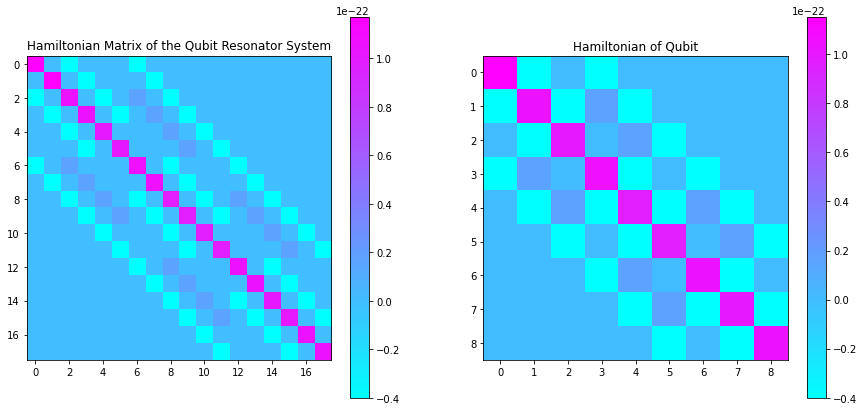

In [15]:
system = SparseSystem(ncut=1, mcut=2, ng=-0.5)

H_qr = system.get_H_qr()
H_q = system.get_H_q()

if type(H_q) == scipy.sparse.csr.csr_matrix:
    H_q = H_q.toarray()
    H_qr = H_qr.toarray()

f = plt.figure(figsize=(15,7))

ax1 = f.add_subplot(121)
ax1.title.set_text('Hamiltonian Matrix of the Qubit Resonator System')
im1 = ax1.imshow(np.real(H_qr), cmap=plt.get_cmap('cool'))
f.colorbar(im1)

ax2 = f.add_subplot(122)
ax2.title.set_text('Hamiltonian of Qubit')
im2 = ax2.imshow(np.real(H_q), cmap=plt.get_cmap('cool'))
f.colorbar(im2)
plt.show()

/tmp/ipykernel_9838/2305995065.py:6: DeprecationWarning: Please use `csr_matrix` from the `scipy.sparse` namespace, the `scipy.sparse.csr` namespace is deprecated.
  if type(kin_q) == scipy.sparse.csr.csr_matrix:


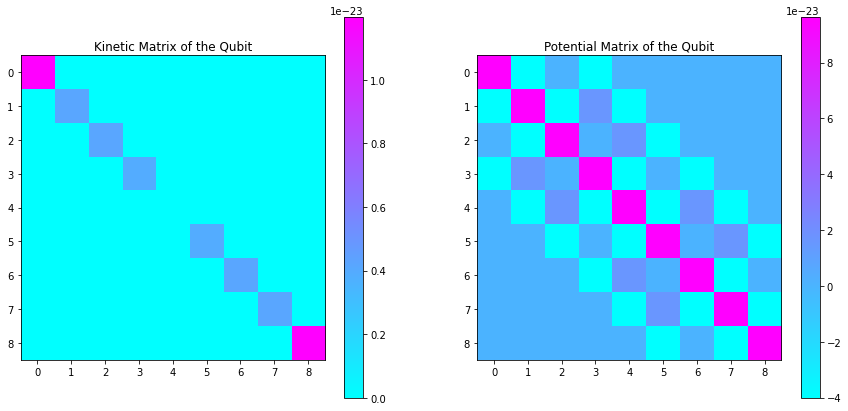

In [16]:
system = SparseSystem(ncut=1, mcut=2, ng=0, EJ=121e9)

kin_q = system.kin_q()
pot_q = system.pot_q()

if type(kin_q) == scipy.sparse.csr.csr_matrix:
    kin_q = kin_q.toarray()
    pot_q = pot_q.toarray()

f = plt.figure(figsize=(15,7))

ax1 = f.add_subplot(121)
ax1.title.set_text('Kinetic Matrix of the Qubit')
im1 = ax1.imshow(np.real(kin_q), cmap=plt.get_cmap('cool'))
f.colorbar(im1)

ax2 = f.add_subplot(122)
ax2.title.set_text('Potential Matrix of the Qubit')
im2 = ax2.imshow(np.real(pot_q), cmap=plt.get_cmap('cool'))
f.colorbar(im2)
plt.show()

### Direct Qubit Simulation

#### Fig 17a

In [18]:
fig_17a_ngs_q = np.linspace(-20, 20, 100)
alphas = np.linspace(0.25, 0.6, 2)

system = SparseSystem(ncut=6, Cc=0)

fig_17a_results_q = {}

for alpha in alphas:
    fig_17a_results_q[alpha] = []
    system.alpha = alpha
    for ng in tqdm(fig_17a_ngs_q):

        system.ng = ng

        evals, evecs = system.diagonalise_q(update=True)
        evals = np.real(evals) * 1e-9 / h

        delta = (evals[1] - evals[0]) / 2

        fig_17a_results_q[alpha].append(delta)

100%|█████████████████████████████████████████| 100/100 [00:15<00:00,  6.51it/s]


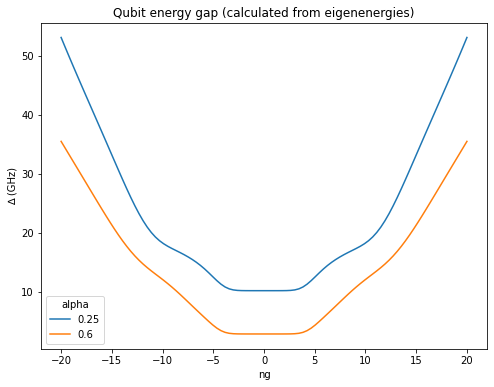

In [19]:
plt.figure(figsize=(8,6))
plt.title('Qubit energy gap (calculated from eigenenergies)')
plt.xlabel('ng')
plt.ylabel('∆ (GHz)')

for alpha in fig_17a_results_q.keys():
    plt.plot(fig_17a_ngs_q, fig_17a_results_q[alpha], label=alpha)
plt.legend(title='alpha')
plt.show()

#### Fig 17b

In [20]:
fig_17b_ngs_q = np.linspace(-20, 20, 200)
Ccs = np.linspace(0, 10e-15, 2)

system = SparseSystem(ncut=6, alpha=0.4)

fig_17b_results_q = {}

for Cc in Ccs:
    fig_17b_results_q[Cc] = []
    system.Cc = Cc
    for ng in tqdm(fig_17b_ngs_q):

        system.ng = ng

        evals, evecs = system.diagonalise_q(update=True)
        evals = np.real(evals) * 1e-9 / h

        delta = (evals[1] - evals[0]) / 2

        fig_17b_results_q[Cc].append(delta)

100%|█████████████████████████████████████████| 200/200 [00:29<00:00,  6.81it/s]


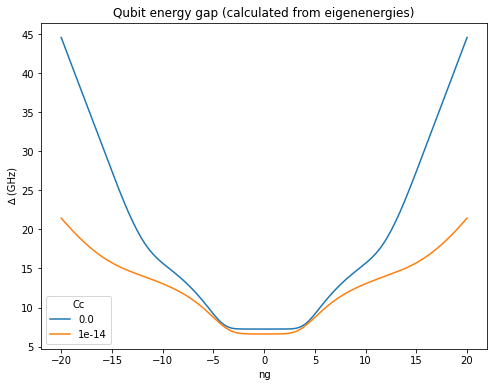

In [21]:
plt.figure(figsize=(8,6))
plt.title('Qubit energy gap (calculated from eigenenergies)')
plt.xlabel('ng')
plt.ylabel('∆ (GHz)')

for Cc in fig_17b_results_q.keys():
    plt.plot(fig_17b_ngs_q, fig_17b_results_q[Cc], label=Cc)
plt.legend(title='Cc')
plt.show()

#### Fig 17c

In [22]:
fig_17c_ngs = np.linspace(-20, 20, 100)
Ccs = np.linspace(1e-15, 8e-15, 5)

system = SparseSystem(ncut=7, alpha=0.4)

fig_17c_results = {}
fig_17c_g_perp_results = {}

for Cc in Ccs:
    fig_17c_results[Cc] = []
    fig_17c_g_perp_results[Cc] = []
    system.Cc = Cc
    for ng in tqdm(fig_17c_ngs):
        system.ng = ng

        system.init_qubit_states(update=True)
        
        H_q_coupling = system.get_H_q_coupling()

        g_parr = np.abs(system.hc(system.qubit_p) @ H_q_coupling @ system.qubit_m) # Try taking modulus squared without coefficient
        g_perp = np.abs(system.hc(system.qubit_1) @ H_q_coupling @ system.qubit_0)
        
        g_parr = g_parr * 1e-6 / h
        g_perp = g_perp * 1e-6 / h

        fig_17c_results[Cc].append(g_parr)
        fig_17c_g_perp_results[Cc].append(g_perp)

100%|█████████████████████████████████████████| 100/100 [00:21<00:00,  4.55it/s]


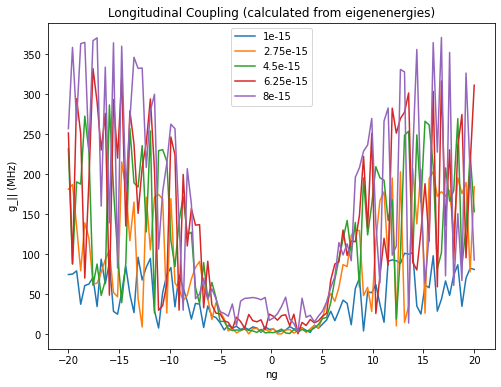

In [23]:
plt.figure(figsize=(8,6))
plt.title('Longitudinal Coupling (calculated from eigenenergies)')
plt.xlabel('ng')
plt.ylabel('g_|| (MHz)')

for Cc in fig_17c_results.keys():
    plt.plot(fig_17c_ngs, fig_17c_results[Cc], label=Cc)
plt.legend()
plt.show()

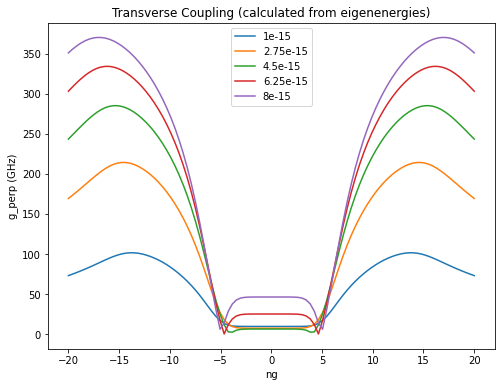

In [24]:
plt.figure(figsize=(8,6))
plt.title('Transverse Coupling (calculated from eigenenergies)')
plt.xlabel('ng')
plt.ylabel('g_perp (GHz)')

for Cc in fig_17c_g_perp_results.keys():
    plt.plot(fig_17c_ngs, fig_17c_g_perp_results[Cc], label=Cc)
plt.legend()
plt.show()

#### Fig 17d

In [25]:
fig_17d_Ccs = np.linspace(0, 10e-15, 200)

system = SparseSystem(ncut=6, alpha=0.4, ng=0.25)

fig_17d_results = []

for Cc in tqdm(fig_17d_Ccs):
    system.Cc = Cc

    system.init_qubit_states(update=True)
    H_q_coupling = system.get_H_q_coupling()

    g_parr = np.abs(system.hc(system.qubit_p) @ H_q_coupling @ system.qubit_m)
    g_parr = g_parr * 1e-6 / h

    fig_17d_results.append(g_parr)

100%|█████████████████████████████████████████| 200/200 [00:34<00:00,  5.74it/s]


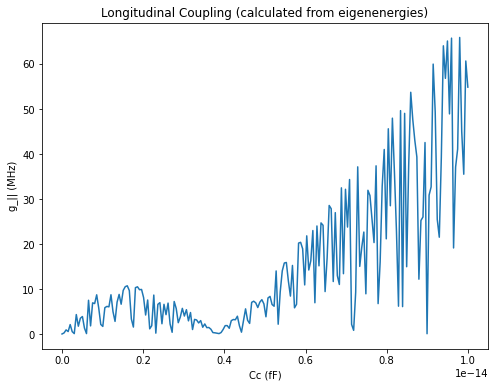

In [26]:
plt.figure(figsize=(8,6))
plt.title('Longitudinal Coupling (calculated from eigenenergies)')
plt.xlabel('Cc (fF)')
plt.ylabel('g_|| (MHz)')

plt.plot(fig_17d_Ccs, fig_17d_results)
plt.show()

# Determine Approximate Hamiltonian Parameters

We assume that the Hamiltonian can be approximated by

\begin{equation}
    H = \omega_r' a^\dagger a + \frac{\Delta}{2} \sigma_z + i g_{\parallel} \sigma_z \left( a^\dagger - a \right) + g_{\perp} \sigma_x \left( a^\dagger + a \right)
\end{equation}

which when writing the two subspaces explicitly is written as

\begin{equation}
    H = \omega_r' \mathbb{1} \otimes a^\dagger a + \frac{\Delta}{2} \sigma_z \otimes \mathbb{1} + i g_{\parallel} \sigma_z \otimes \left( a^\dagger - a \right) + g_{\perp} \sigma_x \otimes \left( a^\dagger + a \right)
\end{equation}

To find the parameters I previously took the following overlaps:

\begin{equation}
    \langle 0 | \langle 0 | H | 0 \rangle | 0 \rangle = \frac{\Delta}{2}
\end{equation}

\begin{equation}
    \langle 0 | \langle 1 | H | 0 \rangle | 1 \rangle = \omega_r' + \frac{\Delta}{2}
\end{equation}

\begin{equation}
    \langle + | \langle 1 | H | - \rangle | 0 \rangle = i g_{\parallel}
\end{equation}

\begin{equation}
    \langle 1 | \langle 1 | H | 0 \rangle | 0 \rangle = g_{\perp}
\end{equation}

where we use the notation $| \text{Qubit} \rangle | \text{Cavity} \rangle$

This did not yield the expected results for $ \Delta $ (but did yield correct* results for $\omega$ and the couplings), instead for $\Delta$ taking:

\begin{equation}
    \langle 1 | \langle 0 | H | 1 \rangle | 0 \rangle - \langle 0 | \langle 0 | H | 0 \rangle | 0 \rangle = \frac{\Delta}{2}
\end{equation}

has yielded the Qubit + Resontar graphs of fig17(a,b)

*correct up to a factor of ~1.8x

### Evaluate parameters

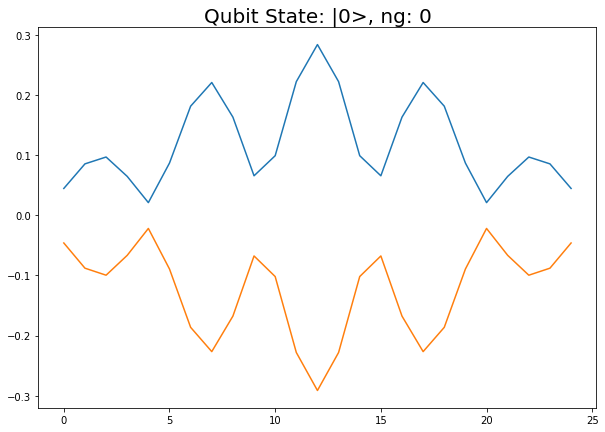

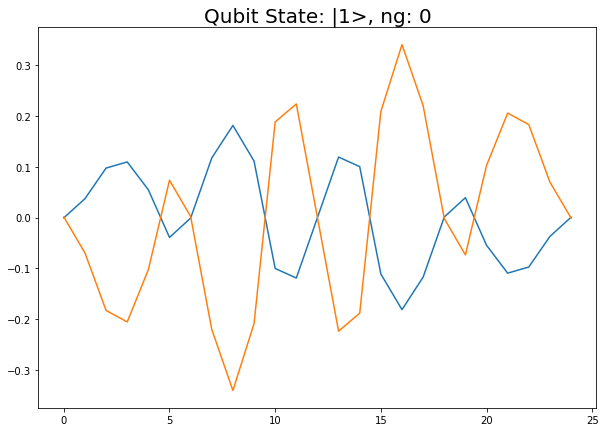

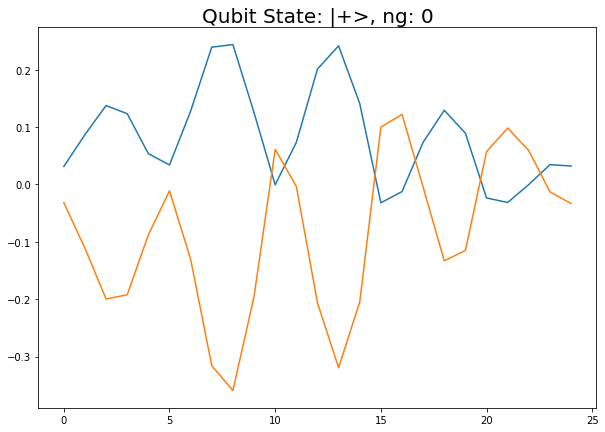

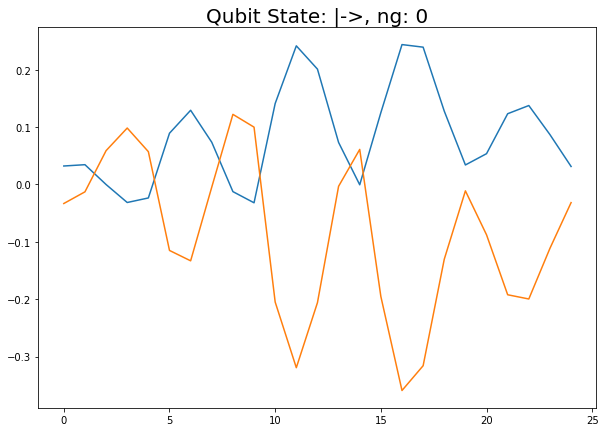

In [27]:
system = SparseSystem(ncut=2, mcut=2, ng=0)
H_q = system._plot_qubit_states()

In [28]:
system = SparseSystem(ncut=5, ng=0.5)

g_parr = system.calc_g_parr()
print(f"g parallel: {g_parr}")

g_perp = system.calc_g_perp()
print(f"g perpendicular: {g_perp}")

delta = system.calc_delta()
print(f"delta: {delta}")

omega = system.calc_omega()
print(f"omega: {omega}")

g parallel: (-3.973584407677877e-28-1.9162772352087076e-25j)
g perpendicular: (-1.9162772352087071e-25-1.1813577590690808e-26j)
delta: (9.21207987454161e-24+2.0203809154758067e-39j)
omega: (-1.2164108215664676e-23-2.4795583962657627e-39j)


### Expected $\omega_r'$

Here we compute the expected resonant frequency of the resonator using the equation

\begin{equation}
    \omega_r' = \hbar / \sqrt{L_r C_r'}
\end{equation}

where $C_r'$ is the renormalised resonator capacitance, as defined in eq A16.

In [29]:
omega_exp = system.calc_bil_omega()
print(f"omega exp: {omega_exp}")

omega exp: 3.2970672320050607e-24


## Calculating Coupling with Eq A15 

In Billangeon et al they express the coupling parameters as:

\begin{equation}
    g_\perp = \langle 1 | \sqrt{\frac{\hbar}{2 Z_r'}} \left[ \alpha (1 + \alpha) \frac{C_c}{C_0^2} (\hat{q}_1 + \hat{q}_2) + (1 + \alpha)^2 \frac{C_c}{C_0^2} \hat{q}_I \right] | 0 \rangle
\end{equation}

\begin{equation}
    g_\parallel = \langle + | \sqrt{\frac{\hbar}{2 Z_r'}} \left[ \alpha (1 + \alpha) \frac{C_c}{C_0^2} (\hat{q}_1 + \hat{q}_2) + (1 + \alpha)^2 \frac{C_c}{C_0^2} \hat{q}_I \right] | - \rangle
\end{equation}

In [30]:
g_parr_bil, g_perp_bil = system.calc_bil_coupling()

print(f"g parallel: {g_parr_bil}")
print(f"g perpendicular: {g_perp_bil}")

AttributeError: 'SparseSystem' object has no attribute 'q3_q'

## Figure 17a

In [ ]:
system = SparseSystem(ncut=6, Cc=0)
fig17a_ngs_qr = np.linspace(-1, 1, 100)
alphas = np.linspace(0.25, 0.6, 8)
fig17a_data_qr = {}

for alpha in alphas:
    system.alpha = alpha
    fig17a_data_qr[alpha] = []
    for ng in tqdm(fig17a_ngs_qr):
        system.ng = ng

        # Full Hamiltonina Approach
        delta = system.calc_delta(update=True)
        fig17a_data_qr[alpha].append(delta)

In [ ]:
plt.figure(figsize=(8,6))
plt.title('Figure 17a: Full Hamiltonian Approach')
plt.xlabel('ng')
plt.ylabel('∆ / h (GHz)')
for alpha in fig17a_data_qr.keys():
    plt.plot(fig17a_ngs_qr, [np.real(delta * 1e-9) / h for delta in fig17a_data_qr[alpha]], label=alpha)
plt.legend(title='alpha')
plt.show()

## Figure 17b

In [ ]:
system = SparseSystem(ncut=6, alpha=0.4)
ngs = np.linspace(-1, 1, 100)
Ccs = np.linspace(0, 10e-15, 5)
fig17b_data = {}

for Cc in Ccs:
    system.Cc = Cc
    fig17b_data[Cc] = []
    for ng in tqdm(ngs):
        system.ng = ng

        # Full Hamiltonina Approach
        delta = system.calc_delta(update=True)
        fig17b_data[Cc].append(delta)

In [ ]:
plt.figure(figsize=(8,6))
plt.title('Figure 17b: Full Hamiltonian Approach')
plt.xlabel('ng')
plt.ylabel('∆ / h (GHz)')
for Cc in fig17b_data.keys():
    plt.plot(ngs, [np.real(delta * 1e-9) / h for delta in fig17b_data[Cc]], label=Cc)
plt.legend(title='Cc')
plt.show()

## Figure 17c

In [ ]:
system = SparseSystem(ncut=5, alpha=0.4)
fig17c_ngs_qr = np.linspace(-20, 20, 100)
fig_17c_Ccs_qr = np.linspace(1e-15, 8e-15, 2)
fig17c_data_qr = {}

for Cc in fig_17c_Ccs_qr:
    system.Cc = Cc
    fig17c_data_qr[Cc] = []
    for ng in tqdm(fig17c_ngs_qr):
        system.ng = ng

        # Full Hamiltonina Approach
        g_parr = system.calc_g_parr(update=True)
        fig17c_data_qr[Cc].append(g_parr)

In [ ]:
plt.figure(figsize=(8,6))
plt.title('Figure 17c: Full Hamiltonian Approach')
plt.xlabel('ng')
plt.ylabel('g_|| / h (MHz)')
for Cc in fig17c_data_qr.keys():
    plt.plot(fig17c_ngs_qr, [np.abs(g_parr * 1e-6) / h for g_parr in fig17c_data_qr[Cc]], label=Cc)
plt.legend(title='Cc')
plt.show()

## Varying Cc (Figure 17d)

In [ ]:
system = SparseSystem(ncut=8, alpha=0.4)

fig_17d_Ccs_qr = np.linspace(0, 10e-15, 20)
fig17d_data_qr = {}
fig17d_data_qr['FH'] = []
fig17d_data_qr['Bil'] = []

for Cc in tqdm(fig_17d_Ccs_qr):
    system.Cc = Cc
    
    # Full Hamiltonina Approach
    g_parr = system.calc_g_parr(update=True)
    fig17d_data_qr['FH'].append(g_parr)

    # Billangeon Eq A15 Approach
    g_parr_bil, g_perp_bil = system.calc_bil_coupling(update=True)
    fig17d_data_qr['Bil'].append(g_parr_bil)

In [ ]:
plt.figure(figsize=(8,6))

# ax1 = f.add_subplot(121)
plt.title('Figure 17d: Full Hamiltonnian Result')
plt.xlabel('Cc')
plt.ylabel('g_|| / h (MHz)')
plt.plot(fig_17d_Ccs_qr, [np.abs(g_parr * 1e-6) / h for g_parr in fig17d_data_qr['FH']])

# ax2 = f.add_subplot(122)
# ax2.title.set_text('Eq A15 coupling result')
# ax2.set_xlabel('Cc')
# ax2.set_ylabel('g_|| / h (MHz)')
# ax2.plot(fig_17d_Ccs_qr, [np.abs(g_parr_bil * 1e-6) / h for g_parr_bil in fig17d_data_qr['Bil']])
plt.show()